In [145]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn import preprocessing
from sklearn.model_selection import KFold

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [215]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(NN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, out_size)
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

# Predict for the 1,2,3,4,5 classes for yData

In [469]:
xTrain = pd.read_csv("xTrain.csv",index_col = 0).to_numpy()
xTest  = pd.read_csv("xTest.csv",index_col = 0).to_numpy()
yTrain1 = pd.read_csv("CateyTrain.csv")['1'].to_numpy()
yTest1 = pd.read_csv("CateyTest.csv")['1'].to_numpy()
#encode y_label
le = preprocessing.LabelEncoder()
le.fit(np.append(yTrain1, yTest1))
yTest1 = le.transform(yTest1)
yTrain1 = le.transform(yTrain1)
ros = RandomOverSampler(random_state = 0)
xTrain, yTrain1 = ros.fit_resample(xTrain,yTrain1)

In [470]:
len(yTrain1)

18288

In [471]:
#hyper parameters
input_size = len(xTrain[0])
out_size = len(np.unique(np.append(yTrain1, yTest1)))
hidden_size =200
num_epoch = 10
learning_rate = 0.0005

model = NN(input_size, hidden_size, out_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
fcount += 1
xtr, xte = torch.Tensor(xTrain), torch.Tensor(xTest)
ytr, yte = torch.Tensor(yTrain1).long(), torch.Tensor(yTest1).long()
#begin training for this batch
for ep in range(num_epoch):
    batch_size = 10
    index = 0
    total_length = len(xtr)
    while(index < total_length):
        start = index
        if index + batch_size > total_length:
            end = total_length
        else:
            end = index + batch_size
        xxtr = xtr[start:end]
        yytr = ytr[start:end]
        output = model(xtr)
        loss = criterion(output, ytr)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        index = index + batch_size
    print(f" {ep + 1} / {num_epoch} epochs, loss = {loss.item():.4f}")
# test this fold
with torch.no_grad():
    n_correct = 0
    n_sample = 0
    output = model(xte)
    _, predictions = torch.max(output, 1)
    n_sample += len(yte)
    n_correct += (predictions == yte).sum().item()
acc = n_correct / n_sample


 1 / 10 epochs, loss = 0.3687
 2 / 10 epochs, loss = 0.3066
 3 / 10 epochs, loss = 0.2784
 4 / 10 epochs, loss = 0.2620
 5 / 10 epochs, loss = 0.2491
 6 / 10 epochs, loss = 0.2384
 7 / 10 epochs, loss = 0.2300
 8 / 10 epochs, loss = 0.2224
 9 / 10 epochs, loss = 0.2171
 10 / 10 epochs, loss = 0.2241


In [472]:
print(acc)

0.6435523114355232


In [473]:
truth   = np.zeros(4)
predict = np.zeros(4)
correct = np.zeros(4)
with torch.no_grad():
    for index in range(len(xte)):
        x = torch.empty(1,len(xte[index]))
        x[0] = xte[index]
        y = yte[index]
        output = model(x)
        _, p = torch.max(output,1)
        predict[p] += 1
        truth[y] += 1
        correct[p] += int(p == y)


In [474]:
precision = correct / predict
recall    = correct / truth
f1 = 2 * (precision * recall)/ (precision + recall)
print(precision)
print(recall)
print(f1)

[0.02439024 0.07185629 0.26395939 0.85062987]
[0.11111111 0.18461538 0.36027714 0.72383869]
[0.04       0.10344828 0.3046875  0.78212907]


# Some data visualization

In [396]:
xTrain = pd.read_csv("xTrain.csv",index_col = 0)
xTest  = pd.read_csv("xTest.csv",index_col = 0)
xData  = pd.concat([xTrain, xTest])
yTrain = pd.read_csv("yTrain.csv")['numerical']
yTest  = pd.read_csv("yTest.csv")['numerical']
yData  = pd.concat([yTrain, yTest])
ogData = pd.read_csv("googleplaystore.csv")

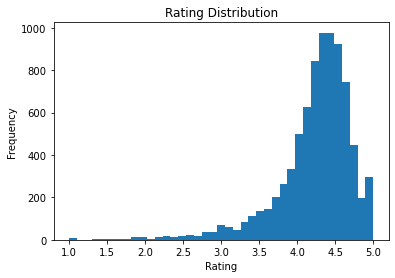

In [434]:
fig1 = yData.hist(grid = False, bins = len(np.unique(yData)))
fig1.set_title("Rating Distribution")
fig1.set_xlabel("Rating")
fig1.set_ylabel("Frequency")
fig1.figure.savefig('Rating_distribution', bbox_inches="tight")

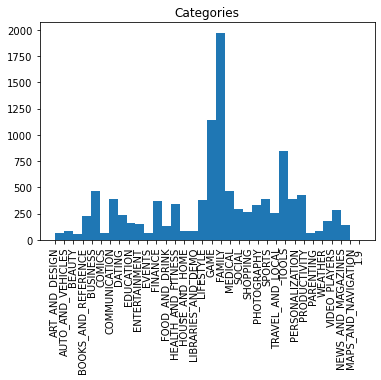

In [433]:
fig2 = ogData["Category"].hist(grid = False, xrot = 90, bins = len(np.unique(ogData["Category"])))
fig2.set_title("Categories")
fig2.figure.savefig('Category_distribution', bbox_inches="tight")

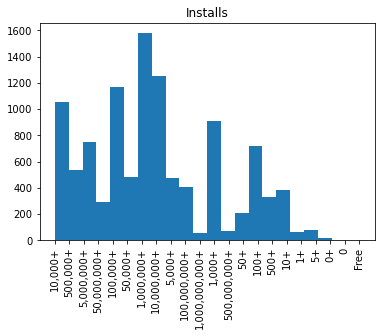

In [435]:
fig2 = ogData["Installs"].hist(grid = False, xrot = 90, bins = len(np.unique(ogData["Installs"])))
fig2.set_title("Installs")
fig2.figure.savefig('Install_distribution', bbox_inches="tight")

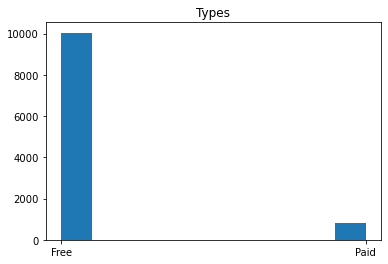

In [436]:
fig2 = ogData["Type"][ogData["Type"] != "0"].hist(grid = False, xrot = 0)
fig2.set_title("Types")
fig2.figure.savefig('Type_distribution', bbox_inches="tight")

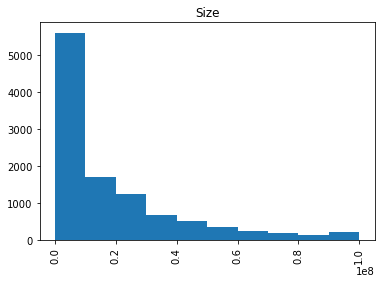

In [438]:
import re
def convert_to_float(x):
    num_list = re.split(",", x)
    temp = ""
    for i in num_list:
        temp += i
    return float(temp)
size_dict = {"M": 1000000, "k":1000, "+":1}
new_size = []
for i in ogData["Size"]:
    if i == "Varies with device":
        new_size.append(0)
    else:
        num = convert_to_float(i[0:len(i)-1])
        new_size.append(num * size_dict[i[len(i)-1]])
fig2 = pd.DataFrame({"Size":new_size}).hist(grid = False, xrot = 90)


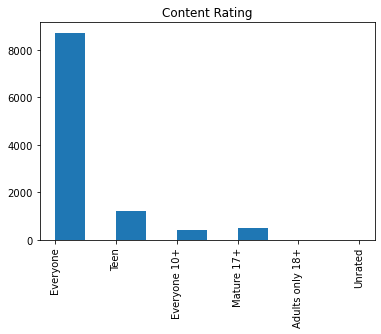

In [437]:
fig2 = ogData["Content Rating"].hist(grid = False, xrot = 90)
fig2.set_title("Content Rating")
fig2.figure.savefig('Content_distribution', bbox_inches="tight")

In [440]:
np.unique(ogData["Genres"])

array(['Action', 'Action;Action & Adventure', 'Adventure',
       'Adventure;Action & Adventure', 'Adventure;Brain Games',
       'Adventure;Education', 'Arcade', 'Arcade;Action & Adventure',
       'Arcade;Pretend Play', 'Art & Design',
       'Art & Design;Action & Adventure', 'Art & Design;Creativity',
       'Art & Design;Pretend Play', 'Auto & Vehicles', 'Beauty', 'Board',
       'Board;Action & Adventure', 'Board;Brain Games',
       'Board;Pretend Play', 'Books & Reference',
       'Books & Reference;Creativity', 'Books & Reference;Education',
       'Business', 'Card', 'Card;Action & Adventure', 'Card;Brain Games',
       'Casino', 'Casual', 'Casual;Action & Adventure',
       'Casual;Brain Games', 'Casual;Creativity', 'Casual;Education',
       'Casual;Music & Video', 'Casual;Pretend Play', 'Comics',
       'Comics;Creativity', 'Communication', 'Communication;Creativity',
       'Dating', 'Education', 'Education;Action & Adventure',
       'Education;Brain Games', 'Education;C

<AxesSubplot:>

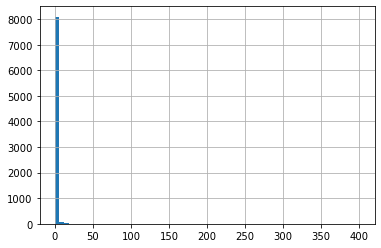

In [451]:
xData["Price"].hist(bins = len(np.unique(xData['Price'])))

In [452]:
sum(xData['Price']>200)

14